[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_E.ipynb)

# オートエンコーダによる画像のデノイジング

以下のセルでオートエンコーダを使ったデノイジングを試すことができます。

Epoch [1/10], Loss: 0.0403
Epoch [2/10], Loss: 0.0304
Epoch [3/10], Loss: 0.0277
Epoch [4/10], Loss: 0.0217
Epoch [5/10], Loss: 0.0251
Epoch [6/10], Loss: 0.0230
Epoch [7/10], Loss: 0.0204
Epoch [8/10], Loss: 0.0191
Epoch [9/10], Loss: 0.0188
Epoch [10/10], Loss: 0.0175
Test Loss: 0.0199


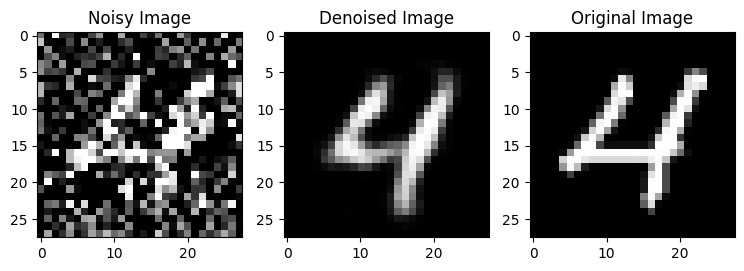

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# データの前処理
transform = transforms.Compose([transforms.ToTensor()])

# MNISTデータセットの読み込み
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# オートエンコーダの定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # ピクセル値を[0, 1]にスケーリング
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# モデルの初期化
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練関数
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            # ノイズの追加
            noisy_img = img + 0.5 * torch.randn(img.shape)  # ノイズを加える
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            # 順伝搬と損失計算
            output = model(noisy_img)
            loss = criterion(output, img)

            # 逆伝搬と最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 訓練の実行
train(model, train_loader, criterion, optimizer, num_epochs=10)

# 結果の可視化
def show_images(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            noisy_img = img + 0.5 * torch.randn(img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            output = model(noisy_img)
            output = output.view(-1, 1, 28, 28)

            # ノイズ付き画像、再構成画像、元の画像を表示
            fig, axes = plt.subplots(1, 3, figsize=(9, 3))
            axes[0].imshow(noisy_img.view(-1, 1, 28, 28)[0].cpu().numpy().squeeze(), cmap='gray')
            axes[0].set_title("Noisy Image")
            axes[1].imshow(output[0].cpu().numpy().squeeze(), cmap='gray')
            axes[1].set_title("Denoised Image")
            axes[2].imshow(img.view(-1, 1, 28, 28)[0].cpu().numpy().squeeze(), cmap='gray')
            axes[2].set_title("Original Image")
            plt.show()
            break

# テストデータセットの読み込み
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# テスト関数の定義
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            # ノイズの追加
            noisy_img = img + 0.5 * torch.randn(img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            # モデルの出力と損失の計算
            output = model(noisy_img)
            loss = criterion(output, img)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

# テストデータでの評価
evaluate(model, test_loader, criterion)

# 結果の表示
show_images(model, train_loader)
